In [1]:
# File 2: Exploratory Data Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Load cleaned data
print("Loading cleaned datasets...")

sentiment_df = pd.read_csv('cleaned_sentiment.csv')
merged_df = pd.read_csv('cleaned_merged_trades.csv')
daily_stats = pd.read_csv('daily_trader_stats.csv')
trader_stats = pd.read_csv('trader_performance_summary.csv')

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
merged_df['trade_date'] = pd.to_datetime(merged_df['trade_date'])
daily_stats['date'] = pd.to_datetime(daily_stats['date'])

print(f"Loaded {len(sentiment_df)} sentiment records")
print(f"Loaded {len(merged_df)} trade records")
print(f"Loaded {len(daily_stats)} daily stats")
print(f"Loaded {len(trader_stats)} trader profiles")

Loading cleaned datasets...
Loaded 2644 sentiment records
Loaded 211224 trade records
Loaded 2341 daily stats
Loaded 32 trader profiles


In [4]:
# Basic statistics
print("\n" + "="*60)
print("BASIC STATISTICS")
print("="*60)

print("\nSentiment Distribution:")
print(sentiment_df['sentiment_category'].value_counts())
print("\nSentiment Value Stats:")
print(sentiment_df['fear_greed_value'].describe())

print("\nTrading Statistics:")
print(f"Total trades: {len(merged_df):,}")
print(f"Closed trades: {merged_df['is_closed'].sum():,}")
print(f"Profitable trades: {merged_df['is_profitable'].sum():,}")
print(f"Win rate (closed): {(merged_df['is_profitable'].sum() / merged_df['is_closed'].sum() * 100):.2f}%")

print("\nPnL Statistics:")
closed_trades = merged_df[merged_df['is_closed']]
print(f"Total PnL: ${closed_trades['Closed_PnL'].sum():,.2f}")
print(f"Average PnL: ${closed_trades['Closed_PnL'].mean():,.2f}")
print(f"Median PnL: ${closed_trades['Closed_PnL'].median():,.2f}")
print(f"Max Profit: ${closed_trades['Closed_PnL'].max():,.2f}")
print(f"Max Loss: ${closed_trades['Closed_PnL'].min():,.2f}")


BASIC STATISTICS

Sentiment Distribution:
sentiment_category
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64

Sentiment Value Stats:
count    2644.000000
mean       46.981089
std        21.827680
min         5.000000
25%        28.000000
50%        46.000000
75%        66.000000
max        95.000000
Name: fear_greed_value, dtype: float64

Trading Statistics:
Total trades: 211,224
Closed trades: 104,408
Profitable trades: 86,869
Win rate (closed): 83.20%

PnL Statistics:
Total PnL: $10,296,958.94
Average PnL: $98.62
Median PnL: $6.06
Max Profit: $135,329.09
Max Loss: $-117,990.10



TIME SERIES ANALYSIS


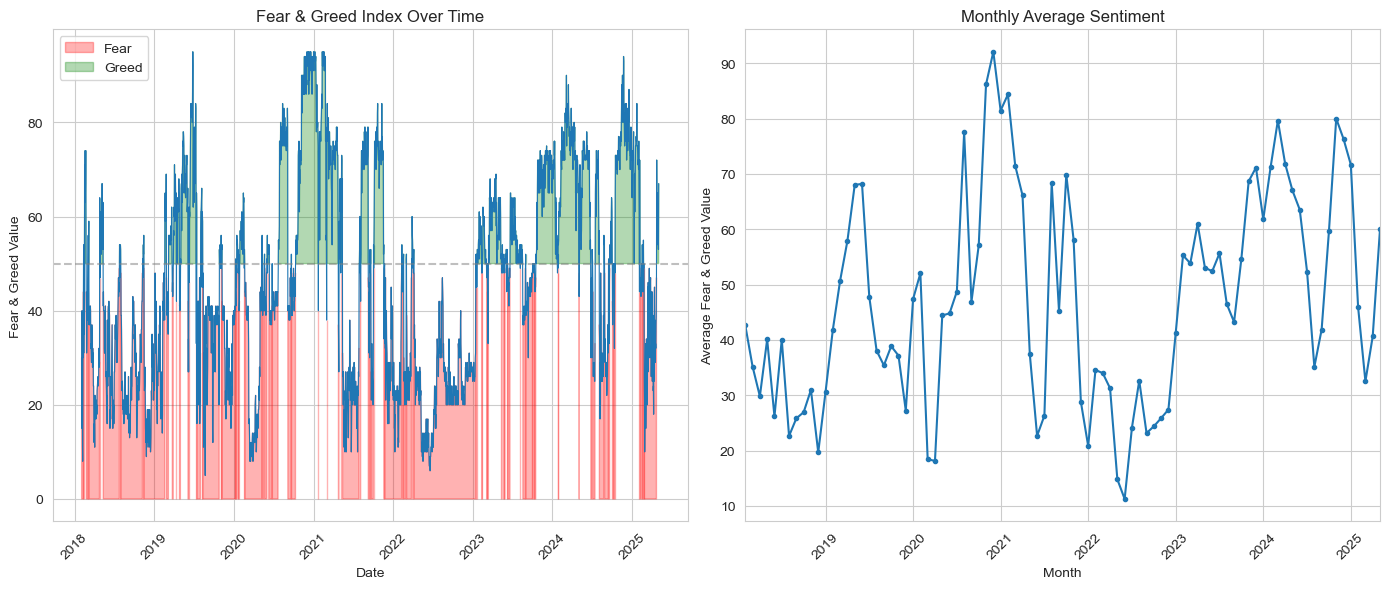

In [5]:
# Sentiment over time
print("\n" + "="*60)
print("TIME SERIES ANALYSIS")
print("="*60)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(sentiment_df['date'], sentiment_df['fear_greed_value'], linewidth=0.8)
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
plt.fill_between(sentiment_df['date'], 0, sentiment_df['fear_greed_value'], 
                 where=(sentiment_df['fear_greed_value'] < 50), alpha=0.3, color='red', label='Fear')
plt.fill_between(sentiment_df['date'], 50, sentiment_df['fear_greed_value'], 
                 where=(sentiment_df['fear_greed_value'] >= 50), alpha=0.3, color='green', label='Greed')
plt.title('Fear & Greed Index Over Time')
plt.xlabel('Date')
plt.ylabel('Fear & Greed Value')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
monthly_sentiment = sentiment_df.groupby(sentiment_df['date'].dt.to_period('M'))['fear_greed_value'].mean()
monthly_sentiment.plot(kind='line', marker='o', markersize=3)
plt.title('Monthly Average Sentiment')
plt.xlabel('Month')
plt.ylabel('Average Fear & Greed Value')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('sentiment_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

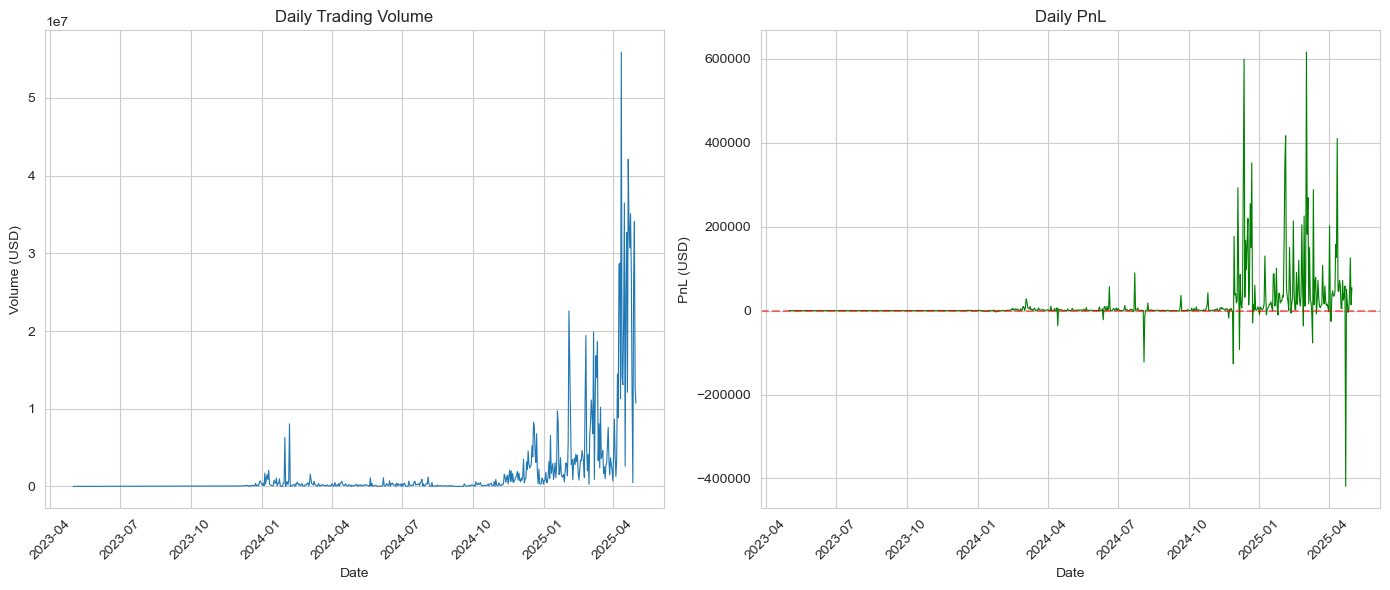

In [9]:
# Trading volume over time
plt.figure(figsize=(14, 6))

daily_volume = merged_df.groupby('trade_date').agg({
    'Size_USD': 'sum',
    'Closed_PnL': 'sum'
}).reset_index()

plt.subplot(1, 2, 1)
plt.plot(daily_volume['trade_date'], daily_volume['Size_USD'], linewidth=0.8)
plt.title('Daily Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume (USD)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.plot(daily_volume['trade_date'], daily_volume['Closed_PnL'], linewidth=0.8, color='green')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.title('Daily PnL')
plt.xlabel('Date')
plt.ylabel('PnL (USD)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('trading_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()


DISTRIBUTION ANALYSIS


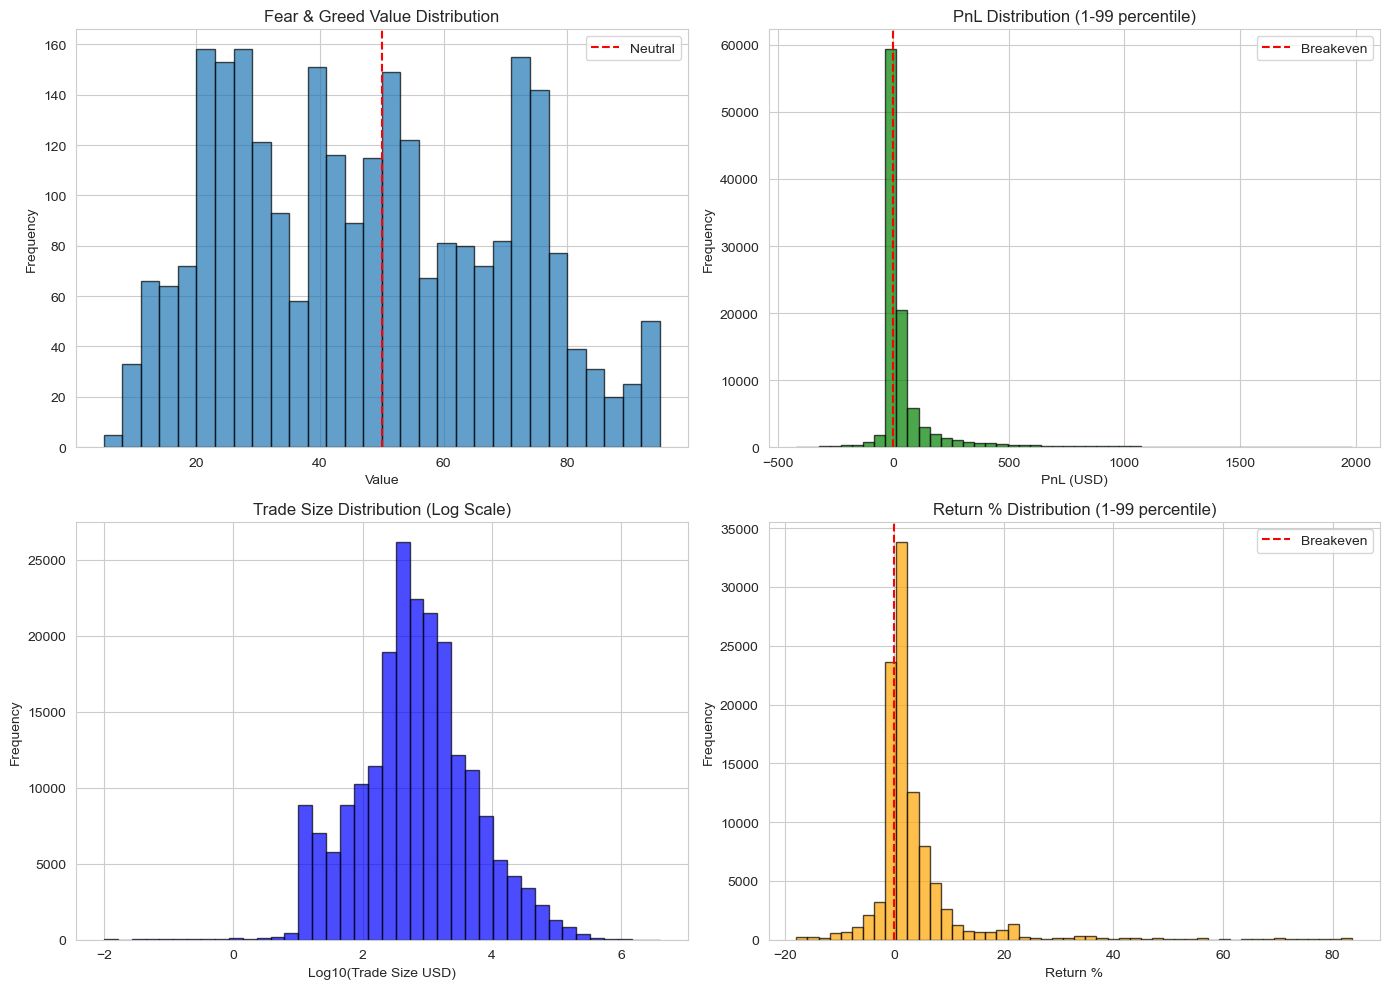

In [11]:
# Distribution analysis
print("\n" + "="*60)
print("DISTRIBUTION ANALYSIS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sentiment distribution
axes[0, 0].hist(sentiment_df['fear_greed_value'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=50, color='red', linestyle='--', label='Neutral')
axes[0, 0].set_title('Fear & Greed Value Distribution')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# PnL distribution
pnl_closed = closed_trades['Closed_PnL']
axes[0, 1].hist(pnl_closed[pnl_closed.between(pnl_closed.quantile(0.01), pnl_closed.quantile(0.99))], 
                bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].axvline(x=0, color='red', linestyle='--', label='Breakeven')
axes[0, 1].set_title('PnL Distribution (1-99 percentile)')
axes[0, 1].set_xlabel('PnL (USD)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Trade size distribution
axes[1, 0].hist(np.log10(merged_df[merged_df['Size_USD'] > 0]['Size_USD']), 
                bins=40, edgecolor='black', alpha=0.7, color='blue')
axes[1, 0].set_title('Trade Size Distribution (Log Scale)')
axes[1, 0].set_xlabel('Log10(Trade Size USD)')
axes[1, 0].set_ylabel('Frequency')

# Return percentage distribution
return_closed = closed_trades[closed_trades['return_pct'] != 0]['return_pct']
axes[1, 1].hist(return_closed[return_closed.between(return_closed.quantile(0.01), return_closed.quantile(0.99))], 
                bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].axvline(x=0, color='red', linestyle='--', label='Breakeven')
axes[1, 1].set_title('Return % Distribution (1-99 percentile)')
axes[1, 1].set_xlabel('Return %')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('distributions.png', dpi=300, bbox_inches='tight')
plt.show()


CORRELATION ANALYSIS


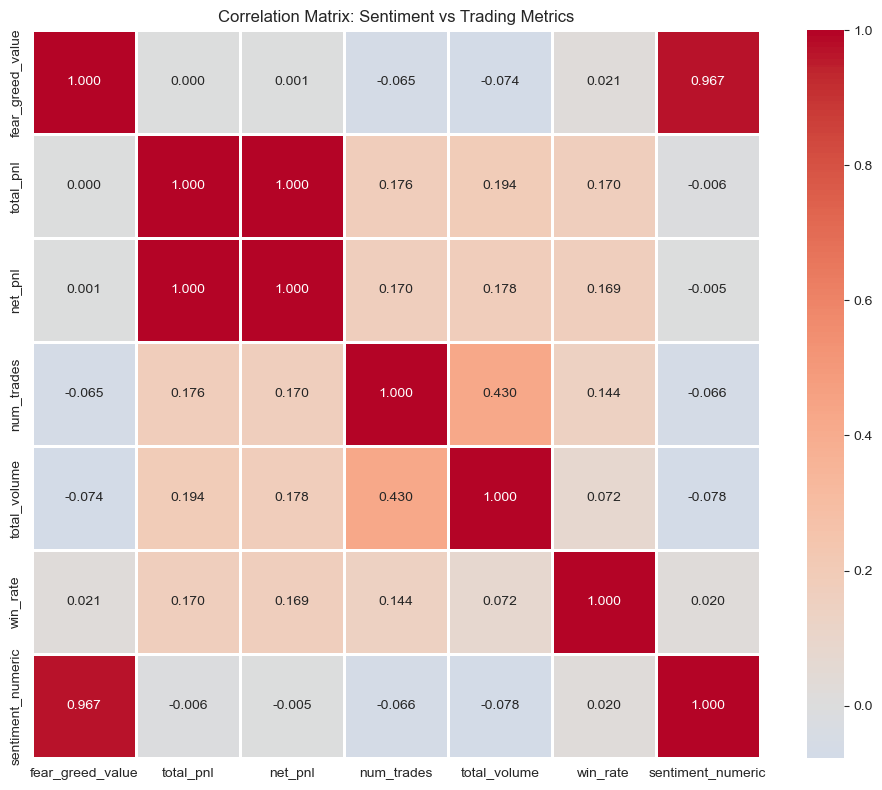


Key Correlations:
fear_greed_value     1.000000
sentiment_numeric    0.967015
win_rate             0.020799
net_pnl              0.001345
total_pnl            0.000179
num_trades          -0.065340
total_volume        -0.074367
Name: fear_greed_value, dtype: float64


In [12]:
# Correlation analysis
print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Prepare correlation data
corr_data = daily_stats[['fear_greed_value', 'total_pnl', 'net_pnl', 'num_trades', 
                          'total_volume', 'win_rate', 'sentiment_numeric']].dropna()

correlation_matrix = corr_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1)
plt.title('Correlation Matrix: Sentiment vs Trading Metrics')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nKey Correlations:")
print(correlation_matrix['fear_greed_value'].sort_values(ascending=False))


TRADER PERFORMANCE ANALYSIS

Top 10 Traders by Net PnL:
                                      Account       net_pnl    win_rate  \
0  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  2.127387e+06   79.104953   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  1.592825e+06   79.272517   
2  0xbaaaf6571ab7d571043ff1e313a9609a10637864  9.315671e+05   99.119736   
3  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  8.227277e+05   76.307037   
4  0x513b8629fe877bb581bf244e326a047b249c4ff1  7.639979e+05   89.547610   
5  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4  6.697211e+05   94.849978   
6  0x72743ae2822edd658c0c50608fd7c5c501b2afbd  4.278041e+05   74.626866   
7  0x430f09841d65beb3f27765503d0f850b8bce7713  4.157949e+05  100.000000   
8  0x72c6a4624e1dffa724e6d00d64ceae698af892a0  4.027215e+05   77.659574   
9  0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4  3.765001e+05   92.632794   

   num_closed_trades  
0               6279  
1               1732  
2               9997  
3              22551  
4 

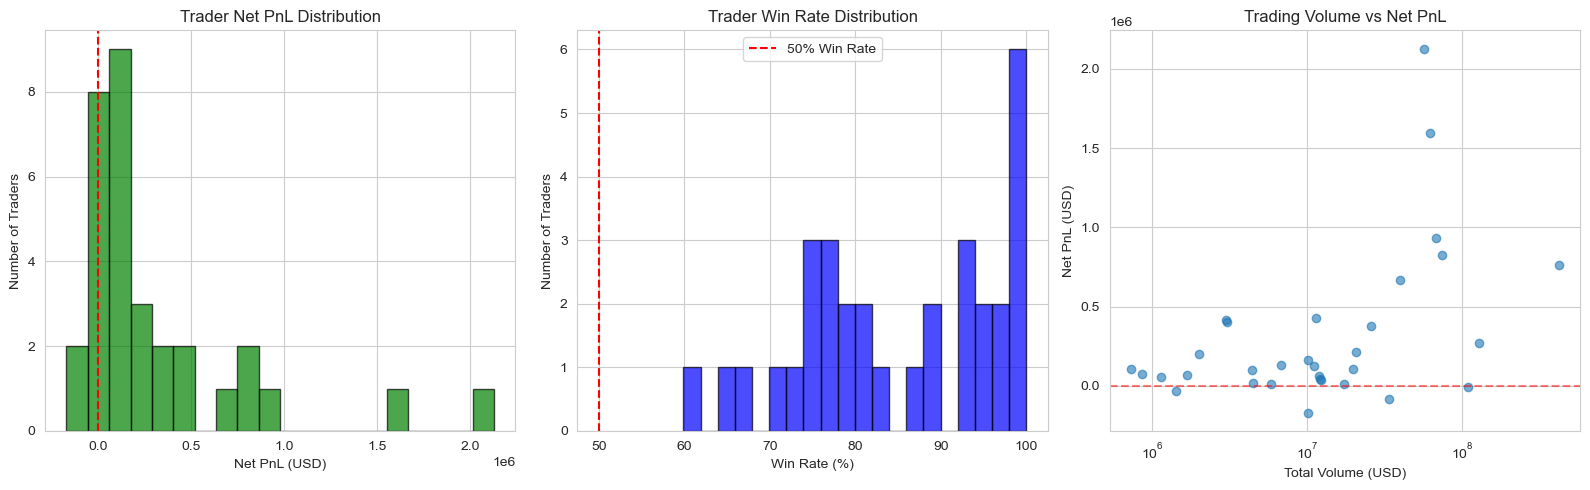

In [13]:
# Trader performance distribution
print("\n" + "="*60)
print("TRADER PERFORMANCE ANALYSIS")
print("="*60)

print("\nTop 10 Traders by Net PnL:")
print(trader_stats[['Account', 'net_pnl', 'win_rate', 'num_closed_trades']].head(10))

print("\nBottom 10 Traders by Net PnL:")
print(trader_stats[['Account', 'net_pnl', 'win_rate', 'num_closed_trades']].tail(10))

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Net PnL distribution
axes[0].hist(trader_stats['net_pnl'], bins=20, edgecolor='black', alpha=0.7, color='green')
axes[0].axvline(x=0, color='red', linestyle='--')
axes[0].set_title('Trader Net PnL Distribution')
axes[0].set_xlabel('Net PnL (USD)')
axes[0].set_ylabel('Number of Traders')

# Win rate distribution
axes[1].hist(trader_stats['win_rate'], bins=20, edgecolor='black', alpha=0.7, color='blue')
axes[1].axvline(x=50, color='red', linestyle='--', label='50% Win Rate')
axes[1].set_title('Trader Win Rate Distribution')
axes[1].set_xlabel('Win Rate (%)')
axes[1].set_ylabel('Number of Traders')
axes[1].legend()

# Trading volume vs PnL
axes[2].scatter(trader_stats['total_volume'], trader_stats['net_pnl'], alpha=0.6)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].set_title('Trading Volume vs Net PnL')
axes[2].set_xlabel('Total Volume (USD)')
axes[2].set_ylabel('Net PnL (USD)')
axes[2].set_xscale('log')

plt.tight_layout()
plt.savefig('trader_performance.png', dpi=300, bbox_inches='tight')
plt.show()


TEMPORAL TRADING PATTERNS


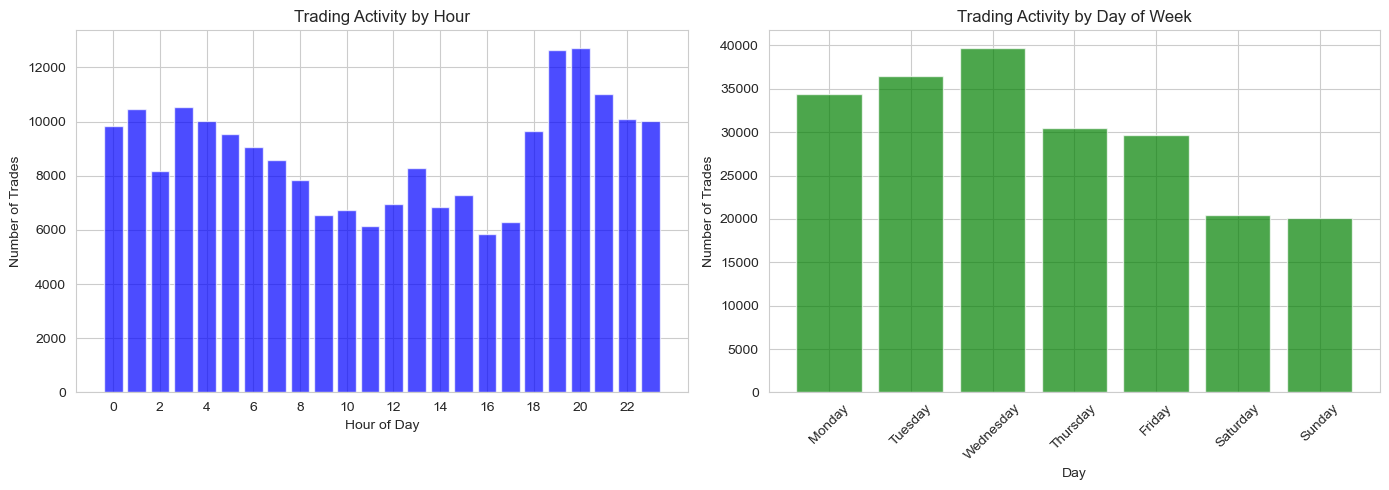

In [14]:
# Trading patterns by time
print("\n" + "="*60)
print("TEMPORAL TRADING PATTERNS")
print("="*60)

# Trading by hour
hourly_trades = merged_df.groupby('hour').agg({
    'Closed_PnL': ['sum', 'mean', 'count']
}).reset_index()
hourly_trades.columns = ['hour', 'total_pnl', 'avg_pnl', 'num_trades']

# Trading by day of week
daily_trades = merged_df.groupby('day_of_week').agg({
    'Closed_PnL': ['sum', 'mean', 'count']
}).reset_index()
daily_trades.columns = ['day_of_week', 'total_pnl', 'avg_pnl', 'num_trades']
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_trades['day_name'] = daily_trades['day_of_week'].map(lambda x: day_names[x])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(hourly_trades['hour'], hourly_trades['num_trades'], alpha=0.7, color='blue')
axes[0].set_title('Trading Activity by Hour')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of Trades')
axes[0].set_xticks(range(0, 24, 2))

axes[1].bar(daily_trades['day_name'], daily_trades['num_trades'], alpha=0.7, color='green')
axes[1].set_title('Trading Activity by Day of Week')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Number of Trades')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('temporal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
print("\nEDA complete. Generated plots:")
print("- sentiment_timeseries.png")
print("- trading_timeseries.png")
print("- distributions.png")
print("- correlation_matrix.png")
print("- trader_performance.png")
print("- temporal_patterns.png")


EDA complete. Generated plots:
- sentiment_timeseries.png
- trading_timeseries.png
- distributions.png
- correlation_matrix.png
- trader_performance.png
- temporal_patterns.png
